In [ ]:
#Importing important libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation,Flatten,Embedding,LSTM,Lambda
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')

tf.config.run_functions_eagerly(True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Loading data from Kaggle
os.mkdir('/content/data')
%cd /content/data/

!kaggle competitions download -c quora-question-pairs

/content/data
 95% 108M/114M [00:01<00:00, 74.8MB/s]
100% 114M/114M [00:01<00:00, 107MB/s] 
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/4.95M [00:00<?, ?B/s]
100% 4.95M/4.95M [00:00<00:00, 152MB/s]
 24% 5.00M/21.2M [00:00<00:00, 48.7MB/s]
100% 21.2M/21.2M [00:00<00:00, 104MB/s] 


In [ ]:
#Extracting data
!unzip /content/data/train.csv.zip

Archive:  /content/data/train.csv.zip
  inflating: train.csv               


In [ ]:
#Loading the train data 
train=pd.read_csv('/content/data/train.csv')
train.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
print('Total number of data points:',train.shape[0])
train.info()

Total number of data points: 404290
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
#Determining the number of null rows
print('Total number of null rows')
train.isnull().sum()

Total number of null rows


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
#Print null rows
train.loc[train['question1'].isnull() | train['question2'].isnull() ,:]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
#Drop null rows

train.dropna(inplace=True)
train.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
#Check for duplicate rows

train[['question1','question2']][train.duplicated(['question1','question2'])==True].sum()

question1    0.0
question2    0.0
dtype: float64

### Analysing Target variable


In [ ]:
#Number of unique values in target variable
train['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [ ]:
#Percentage of 0 and 1 in target variable

num_one=train.loc[train['is_duplicate']==1,'is_duplicate'].count()
num_zero=train.loc[train['is_duplicate']==0,'is_duplicate'].count()

print('Percentage of 1\'s is :',num_one*100/train.shape[0])
print('Percentage of 0\'s is :',num_zero*100/train.shape[0])

Percentage of 1's is : 36.92005926482919
Percentage of 0's is : 63.07994073517081


There is significant reprsentation of both the classes, hence the dataset is not imbalanced

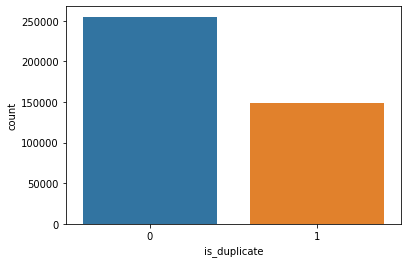

In [ ]:
import seaborn as sns

sns.countplot(data=train,x='is_duplicate')
plt.show()

### Analysing the input

In [ ]:
#Helper functions
def commonWords(text1,text2):
  text1=set(text1.split())
  text2=set(text2.split())
  return len(text1.intersection(text2))

def totalWords(text1,text2):
  cnt1=len(text1.split())
  cnt2=len(text2.split())
  return cnt1+cnt2


In [ ]:
#Computing the frequency of questions
train['freq_q1']=train.groupby('qid1')['qid1'].transform('count')
train['freq_q2']=train.groupby('qid1')['qid2'].transform('count')

#Wordcount
train['count_q1']=train['question1'].apply(lambda x: len(x.split()))
train['count_q2']=train['question2'].apply(lambda x: len(x.split()))

#Common words between question1 and question2
train['common']=train.apply(lambda x: commonWords(x['question1'],x['question2']),axis=1)

#Total number o words in question1 and question2
train['total']=train.apply(lambda x: totalWords(x['question1'],x['question2']),axis=1)

train['normalized_word_share']=train['common']/train['total']

In [ ]:
#Train data after adding new columns
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,count_q1,count_q2,common,total,normalized_word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,14,12,10,26,0.384615
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,4,8,13,4,21,0.190476
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,14,10,3,24,0.125000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,11,9,0,20,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,3,13,7,2,20,0.100000


In [ ]:
#Most frequent questions
mx_value1=max(train['freq_q1'])
lst_qid1=list(set(train['qid1'][train['freq_q1']==mx_value1]))
q1=train['question1'][train['qid1']==lst_qid1[0]].values[0]

print('Most frequent question in question1')
print(q1)
print('************************')

mx_value2=max(train['freq_q2'])
lst_qid2=list(set(train['qid2'][train['freq_q2']==mx_value2]))
q2=train['question2'][train['qid2']==lst_qid2[0]].values[0]

print('Most frequent question in question2')
print(q2)


Most frequent question in question1
How do I improve my English speaking?
************************
Most frequent question in question2
How do I improve my English language?


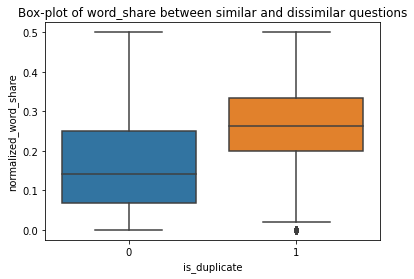

In [ ]:
#Analysing normalised_word_share feature

sns.boxplot(data=train,x='is_duplicate',y='normalized_word_share')
plt.title('Box-plot of word_share between similar and dissimilar questions')
plt.show()

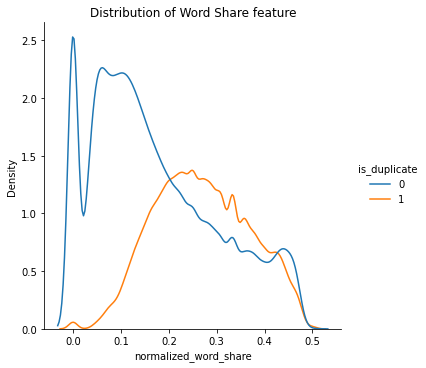

In [ ]:
#Distribution of Word Share feature
ax=sns.displot(data=train,x='normalized_word_share',hue='is_duplicate',kind='kde')
plt.title('Distribution of Word Share feature')
plt.show()

Duplicate questions have higher word share than non-duplicate questions